# Imbalanced MNIST problem

### 1. Load required modules

In [1]:
import numbers
from torch.nn.parameter import Parameter
import torch.nn.init
import torch.nn.utils.weight_norm as weightNorm

import matplotlib as mpl
mpl.use('TkAgg')  # or whatever other backend that you want
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from numpy import linalg as LA
from torchvision.utils import save_image

from torch.optim import lr_scheduler
import pyro
import argparse
import time, os, copy
import numpy as np
import random
from IPython import display

import seaborn as sns
import seaborn as sns

import pandas as pd
import sklearn.metrics as sm

from scipy.stats import norm

from utils import *
from nn_model import *

torch.manual_seed(1)  


In [2]:
%matplotlib inline


### 2. Set hyperparameters for training

In [3]:

# Hyper Parameters

EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 128
TIME_STEP = 5        # rnn time step 
INPUT_SIZE = 784         # rnn input size
WINDOW_WIDTH = 5
WINDOW_SQUARE = WINDOW_WIDTH**2
IS_VISUALIZATION = True 

dtype = torch.FloatTensor



### 3. Load imbalanced MNIST data

In [4]:
train_data, test_data, IMAGE_WIDTH, IMAGE_HEIGHT = prepare_data_mnist()

num_train = len(train_data)
indices = list(range(num_train))

split = 5000
train_size = 60000 - split
valid_size = split
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, sampler=train_sampler, shuffle=False)
valid_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=split, sampler=valid_sampler, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=len(test_data), shuffle=False)

num_classes = 10
classe_labels = range(num_classes)


In [5]:
sample_probs = torch.rand(num_classes)

idx_to_del = [i for i, label in enumerate(train_loader.dataset.train_labels) 
              if random.random() > sample_probs[label]]
imbalanced_train_dataset = copy.deepcopy(train_data)


imbalanced_train_dataset.targets = np.delete(train_loader.dataset.train_labels.numpy(), np.array(idx_to_del), axis=0)
imbalanced_train_dataset.data = np.delete(train_loader.dataset.train_data, idx_to_del, axis=0)
imbalanced_train_loader = torch.utils.data.DataLoader(
    imbalanced_train_dataset, batch_size=BATCH_SIZE, shuffle=True)


/anaconda3/envs/mlenv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/anaconda3/envs/mlenv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Original dataset: 60000 training samples & 10000 testing samples

Distribution of classes in original dataset:


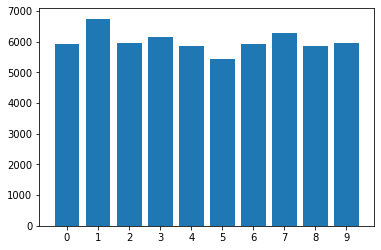

Sampling probability for each class:


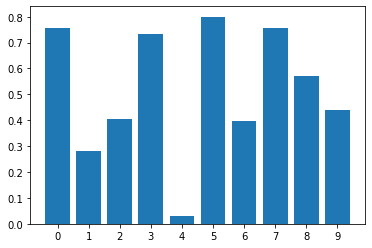

Imbalanced dataset: 30726 training samples & 10000 testing samples

Distribution of classes in imbalanced dataset:


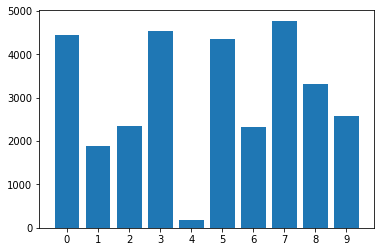

In [6]:

print('Original dataset: %d training samples & %d testing samples\n' % (
    len(train_loader.dataset), len(test_loader.dataset)))
 
print('Distribution of classes in original dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

print('Sampling probability for each class:')
fig, ax = plt.subplots()
ax.bar(classe_labels, sample_probs)
ax.set_xticks(classe_labels)
plt.show()
 
print('Imbalanced dataset: %d training samples & %d testing samples\n' % (
    len(imbalanced_train_loader.dataset), len(test_loader.dataset)))

print('Distribution of classes in imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()


### 4. Test different NN variants with or without MDL normalization

NN(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
)
============================ tensor([0.0100, 0.0100, 1.0000, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 1.0000,
        1.0000])
epoch  0 :  0 / 18179  (0 %)  | train loss:2.3220 | val loss:2.3038 | val acc:0.1022 | Time:1.8272
epoch  0 :  128 / 18179  (1 %)  | train loss:2.2573 | val loss:2.3000 | val acc:0.1332 | Time:2.7542
epoch  0 :  256 / 18179  (1 %)  | train loss:2.0855 | val loss:2.3092 | val acc:0.1672 | Time:3.6523
epoch  0 :  384 / 18179  (2 %)  | train loss:1.9079 | val loss:2.3472 | val acc:0.2144 | Time:4.5935
epoch  0 :  512 / 18179  (3 %)  | train loss:1.6568 | val loss:2.4365 | val acc:0.2364 | Time:5.5014
epoch  0 :  640 / 18179  (4 %)  | train loss:1.4031 | val loss:2.6044 | val acc:0.2340 | Time:6.3990
epoch  0 :  768 / 18179  (4 %)  | train loss:1.2539 | val loss:2.8672 | val

epoch  0 :  9856 / 18179  (54 %)  | train loss:0.2862 | val loss:3.2055 | val acc:0.2802 | Time:72.7373
epoch  0 :  9984 / 18179  (55 %)  | train loss:0.2938 | val loss:3.2176 | val acc:0.2802 | Time:73.6747
epoch  0 :  10112 / 18179  (56 %)  | train loss:0.1511 | val loss:3.2332 | val acc:0.2810 | Time:74.7155
epoch  0 :  10240 / 18179  (56 %)  | train loss:0.2457 | val loss:3.2429 | val acc:0.2808 | Time:75.7529
epoch  0 :  10368 / 18179  (57 %)  | train loss:0.3222 | val loss:3.2480 | val acc:0.2806 | Time:76.7963
epoch  0 :  10496 / 18179  (58 %)  | train loss:0.2494 | val loss:3.2499 | val acc:0.2808 | Time:77.8928
epoch  0 :  10624 / 18179  (58 %)  | train loss:0.1304 | val loss:3.2597 | val acc:0.2808 | Time:78.8518
epoch  0 :  10752 / 18179  (59 %)  | train loss:0.2696 | val loss:3.2713 | val acc:0.2808 | Time:79.8774
epoch  0 :  10880 / 18179  (60 %)  | train loss:0.3328 | val loss:3.2679 | val acc:0.2810 | Time:81.0498
epoch  0 :  11008 / 18179  (61 %)  | train loss:0.2793 | 

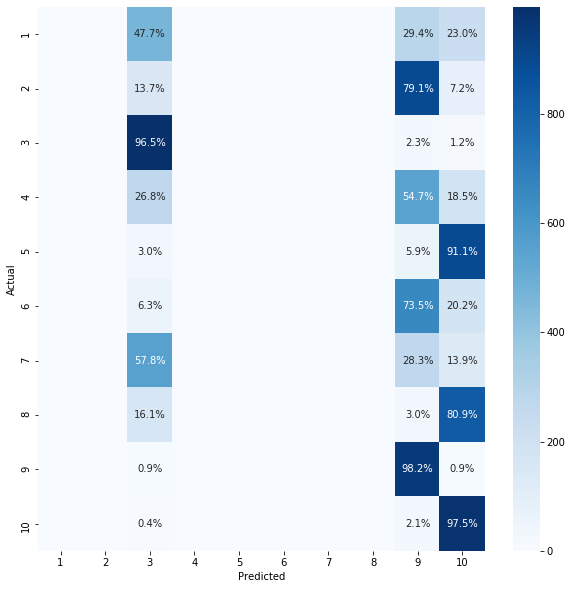

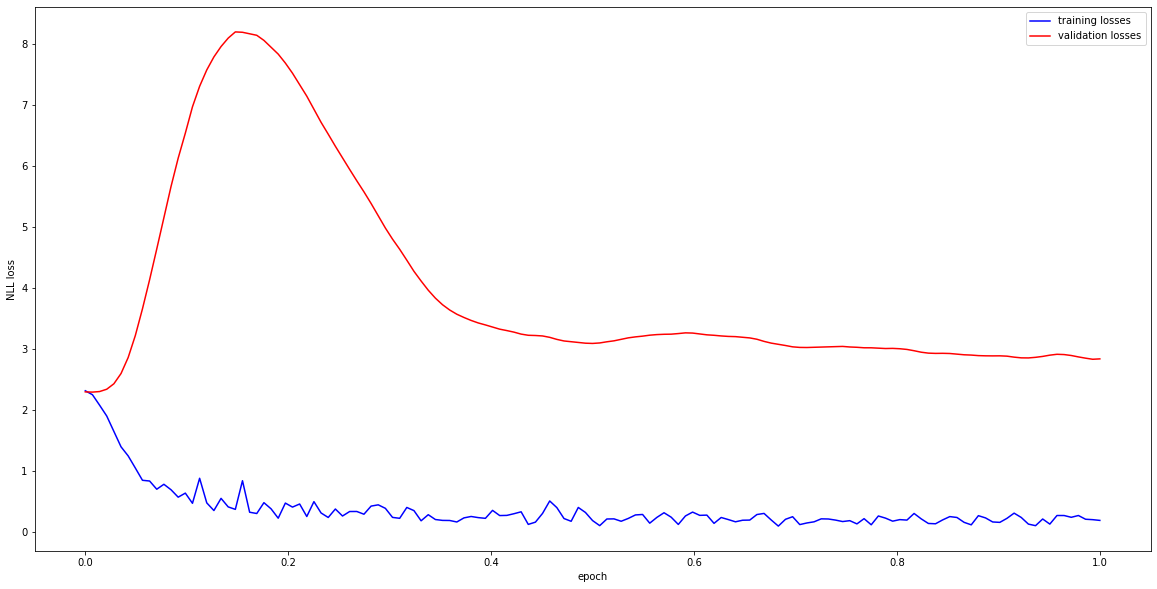

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

seed = 5
n_down = 7
p_down = 0.01

# name = 'imb-nn-784-1000-1000-10-baseline-'+str(seed)+'-'+str(n_down)+'-'+str(p_down)
name = 'test'
model = NN()
model.to(device)
# rnn.cuda()
isImbalanced = True

print(model)
LR = 0.01               # learning rate

# optimizer = torch.optim.Adam(model.parameters(), lr=LR)  # optimize with Adam
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=LR)  # optimize with SGD

# loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
# loss_func = nn.CrossEntropyLoss().cuda()
# loss_func = nn.NLLLoss()

EPOCH = 1
train_losses = []
val_losses = []
test_acces = []

# training and testing
for epoch in range(EPOCH):
    
    train_losses, val_losses, used_train_size = train(seed,n_down,p_down,model, device, train_loader, train_size, valid_loader, valid_size, optimizer, epoch, train_losses, val_losses,isImbalanced)
    test_acces, confusion_mtx = test(model, device, test_loader, test_acces)
    
    torch.save(model.state_dict(),'mnist_'+name+'_epoch_'+str(epoch)+'.pt')
    
    fig = vis_confusion(confusion_mtx, np.arange(10)+1)
    fig.savefig('figures/'+name+'_confusion_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')


    plt.rcParams['figure.figsize'] = [20, 10]
    fig, ax = plt.subplots()
    ax.plot((np.arange(len(train_losses)))*BATCH_SIZE/used_train_size, train_losses, c='blue',label='training losses')
    ax.plot((np.arange(len(val_losses)))*BATCH_SIZE/used_train_size, val_losses, c='red',label='validation losses')
    ax.legend()
    ax.set_xlabel('epoch')
    ax.set_ylabel('NLL loss')
    fig.savefig('figures/'+name+'_loss_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')
    np.save('models/'+name+'_perf_epoch_'+str(epoch)+'.npy',[train_losses,val_losses,test_acces,confusion_mtx])
    
  

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

seed = 5
n_down = 7
p_down = 0.01

name = 'imb-nn-784-1000-1000-10-BN-'+str(seed)+'-'+str(n_down)+'-'+str(p_down)
model = NNBN()
model.to(device)
# rnn.cuda()
isImbalanced = True

print(model)
LR = 0.01               # learning rate

# optimizer = torch.optim.Adam(model.parameters(), lr=LR)  # optimize with Adam
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=LR)  # optimize with SGD

# loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
# loss_func = nn.CrossEntropyLoss().cuda()
# loss_func = nn.NLLLoss()

EPOCH = 1
train_losses = []
val_losses = []
test_acces = []

# training and testing
for epoch in range(EPOCH):
    
    train_losses, val_losses, used_train_size = train(seed,n_down,p_down,model, device, train_loader, train_size, valid_loader, valid_size, optimizer, epoch, train_losses, val_losses,isImbalanced)
    test_acces, confusion_mtx = test(model, device, test_loader, test_acces)
    
    torch.save(model.state_dict(),'mnist_'+name+'_epoch_'+str(epoch)+'.pt')
    
    fig = vis_confusion(confusion_mtx, np.arange(10)+1)
    fig.savefig('figures/'+name+'_confusion_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')

    plt.rcParams['figure.figsize'] = [20, 10]
    fig, ax = plt.subplots()
    ax.plot((np.arange(len(train_losses)))*BATCH_SIZE/used_train_size, train_losses, c='blue',label='training losses')
    ax.plot((np.arange(len(val_losses)))*BATCH_SIZE/used_train_size, val_losses, c='red',label='validation losses')
    ax.legend()
    ax.set_xlabel('epoch')
    ax.set_ylabel('NLL loss')
    fig.savefig('figures/'+name+'_loss_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')
    np.save('models/'+name+'_perf_epoch_'+str(epoch)+'.npy',[train_losses,val_losses,test_acces,confusion_mtx])
    
        

NNLN(
  (input_ln): LayerNorm(torch.Size([784]), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (fc1_ln): LayerNorm(torch.Size([1000]), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc2_ln): LayerNorm(torch.Size([1000]), eps=1e-05, elementwise_affine=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
)
============================ tensor([0.0100, 0.0100, 1.0000, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 1.0000,
        1.0000])
epoch  0 :  0 / 18134  (0 %)  | train loss:2.2545 | val loss:2.6438 | val acc:0.1466 | Time:0.8709
epoch  0 :  128 / 18134  (1 %)  | train loss:1.3408 | val loss:3.6660 | val acc:0.2214 | Time:1.3118
epoch  0 :  256 / 18134  (1 %)  | train loss:0.8277 | val loss:4.7986 | val acc:0.2592 | Time:1.7470
epoch  0 :  384 / 18134  (2 %)  | train loss:0.5837 | val loss:5.8488 | val acc:0.2572 | Time:2.1763
epoch  0 :  512 / 18134  (3 %)  | train 

epoch  0 :  9472 / 18134  (52 %)  | train loss:0.2273 | val loss:2.2994 | val acc:0.3608 | Time:32.9548
epoch  0 :  9600 / 18134  (53 %)  | train loss:0.1999 | val loss:2.2189 | val acc:0.3718 | Time:33.4140
epoch  0 :  9728 / 18134  (54 %)  | train loss:0.1946 | val loss:2.1570 | val acc:0.3768 | Time:33.8413
epoch  0 :  9856 / 18134  (54 %)  | train loss:0.2900 | val loss:2.0868 | val acc:0.3824 | Time:34.2701
epoch  0 :  9984 / 18134  (55 %)  | train loss:0.2174 | val loss:2.0376 | val acc:0.3874 | Time:34.6983
epoch  0 :  10112 / 18134  (56 %)  | train loss:0.1651 | val loss:2.0075 | val acc:0.3840 | Time:35.1194
epoch  0 :  10240 / 18134  (56 %)  | train loss:0.1121 | val loss:1.9899 | val acc:0.3822 | Time:35.5803
epoch  0 :  10368 / 18134  (57 %)  | train loss:0.0457 | val loss:2.0103 | val acc:0.3788 | Time:36.0058
epoch  0 :  10496 / 18134  (58 %)  | train loss:0.1944 | val loss:2.0330 | val acc:0.3726 | Time:36.4330
epoch  0 :  10624 / 18134  (59 %)  | train loss:0.1505 | val

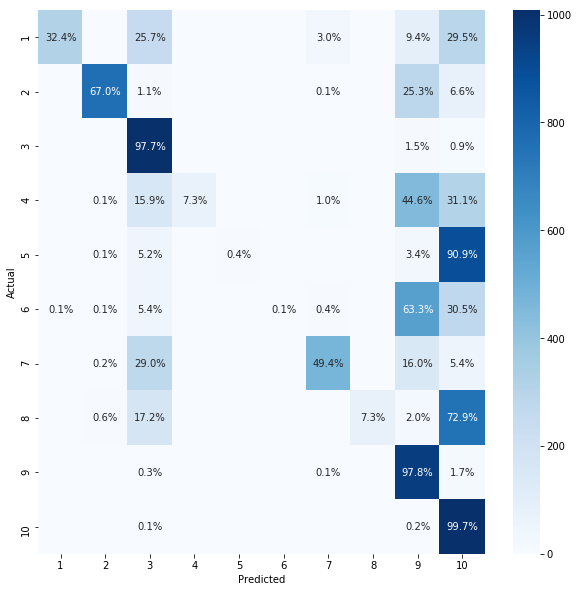

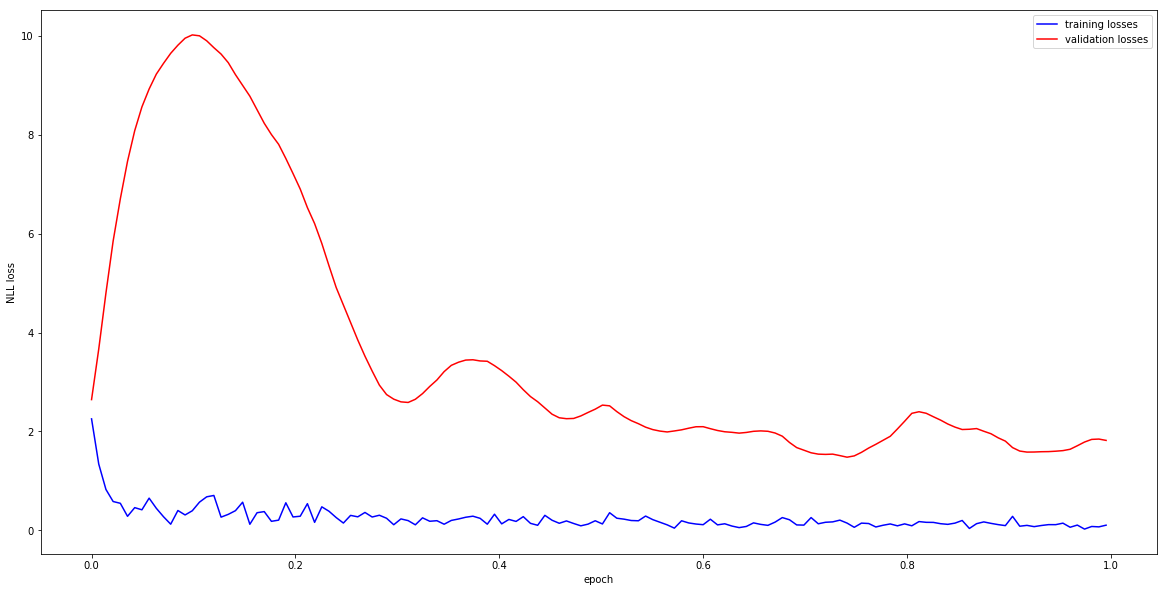

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

seed = 5
n_down = 7
p_down = 0.01

name = 'imb-nn-784-1000-1000-10-LN-'+str(seed)+'-'+str(n_down)+'-'+str(p_down)
model = NNLN()
model.to(device)
# rnn.cuda()
isImbalanced = True

print(model)
LR = 0.01               # learning rate

# optimizer = torch.optim.Adam(model.parameters(), lr=LR)  # optimize with Adam
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=LR)  # optimize with SGD

# loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
# loss_func = nn.CrossEntropyLoss().cuda()
# loss_func = nn.NLLLoss()

EPOCH = 1
train_losses = []
val_losses = []
test_acces = []

# training and testing
for epoch in range(EPOCH):
    
    train_losses, val_losses, used_train_size = train(seed,n_down,p_down,model, device, train_loader, train_size, valid_loader, valid_size, optimizer, epoch, train_losses, val_losses, isImbalanced)
    test_acces, confusion_mtx = test(model, device, test_loader, test_acces)
    
    torch.save(model.state_dict(),'mnist_'+name+'_epoch_'+str(epoch)+'.pt')
    
    fig = vis_confusion(confusion_mtx, np.arange(10)+1)
    fig.savefig('figures/'+name+'_confusion_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')

    plt.rcParams['figure.figsize'] = [20, 10]
    fig, ax = plt.subplots()
    ax.plot((np.arange(len(train_losses)))*BATCH_SIZE/used_train_size, train_losses, c='blue',label='training losses')
    ax.plot((np.arange(len(val_losses)))*BATCH_SIZE/used_train_size, val_losses, c='red',label='validation losses')
    ax.legend()
    ax.set_xlabel('epoch')
    ax.set_ylabel('NLL loss')
    fig.savefig('figures/'+name+'_loss_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')
    np.save('models/'+name+'_perf_epoch_'+str(epoch)+'.npy',[train_losses,val_losses,test_acces,confusion_mtx])
    
        

NNWN(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
)
============================ tensor([0.0100, 0.0100, 1.0000, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 1.0000,
        1.0000])
epoch  0 :  0 / 18188  (0 %)  | train loss:2.2752 | val loss:2.3006 | val acc:0.1022 | Time:0.8474
epoch  0 :  128 / 18188  (1 %)  | train loss:2.1963 | val loss:2.3003 | val acc:0.1364 | Time:1.3084
epoch  0 :  256 / 18188  (1 %)  | train loss:2.0695 | val loss:2.3111 | val acc:0.1596 | Time:1.7666
epoch  0 :  384 / 18188  (2 %)  | train loss:1.9104 | val loss:2.3461 | val acc:0.1858 | Time:2.2268
epoch  0 :  512 / 18188  (3 %)  | train loss:1.7054 | val loss:2.4232 | val acc:0.2134 | Time:2.7238
epoch  0 :  640 / 18188  (4 %)  | train loss:1.5083 | val loss:2.5651 | val acc:0.2194 | Time:3.1783
epoch  0 :  768 / 18188  (4 %)  | train loss:1.3276 | val loss:2.7869 | v

epoch  0 :  9856 / 18188  (54 %)  | train loss:0.2899 | val loss:3.1940 | val acc:0.2776 | Time:36.1963
epoch  0 :  9984 / 18188  (55 %)  | train loss:0.1583 | val loss:3.2143 | val acc:0.2778 | Time:36.6770
epoch  0 :  10112 / 18188  (56 %)  | train loss:0.2338 | val loss:3.2362 | val acc:0.2772 | Time:37.1339
epoch  0 :  10240 / 18188  (56 %)  | train loss:0.1872 | val loss:3.2576 | val acc:0.2776 | Time:37.5829
epoch  0 :  10368 / 18188  (57 %)  | train loss:0.1952 | val loss:3.2707 | val acc:0.2772 | Time:38.0316
epoch  0 :  10496 / 18188  (58 %)  | train loss:0.1917 | val loss:3.2798 | val acc:0.2772 | Time:38.4824
epoch  0 :  10624 / 18188  (58 %)  | train loss:0.2328 | val loss:3.2714 | val acc:0.2774 | Time:38.9665
epoch  0 :  10752 / 18188  (59 %)  | train loss:0.2482 | val loss:3.2651 | val acc:0.2788 | Time:39.4168
epoch  0 :  10880 / 18188  (60 %)  | train loss:0.2678 | val loss:3.2663 | val acc:0.2784 | Time:39.8663
epoch  0 :  11008 / 18188  (61 %)  | train loss:0.3464 | 

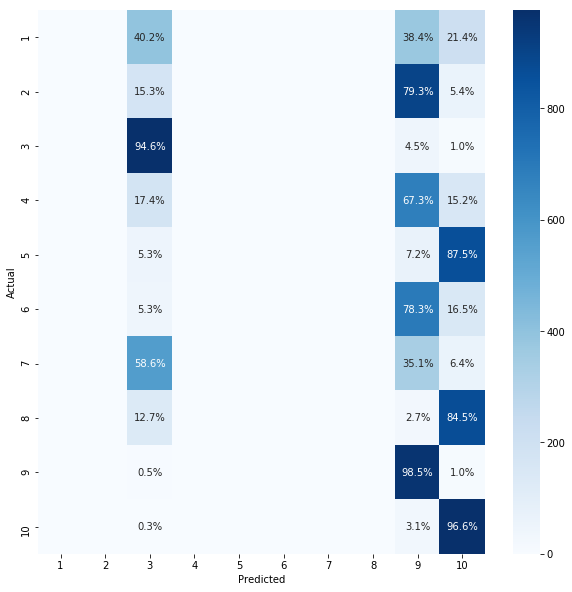

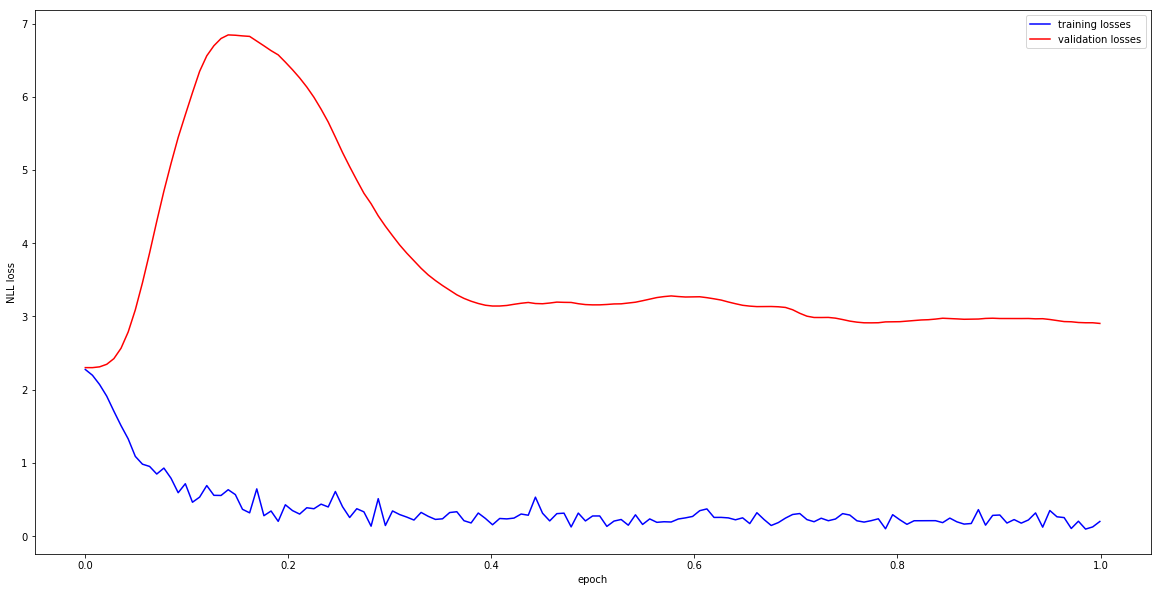

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

seed = 5
n_down = 7
p_down = 0.01

name = 'imb-nn-784-1000-1000-10-WN-'+str(seed)+'-'+str(n_down)+'-'+str(p_down)
model = NNWN()
model.to(device)
# rnn.cuda()
isImbalanced = True

print(model)
LR = 0.01               # learning rate

# optimizer = torch.optim.Adam(model.parameters(), lr=LR)  # optimize with Adam
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=LR)  # optimize with SGD

# loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
# loss_func = nn.CrossEntropyLoss().cuda()
# loss_func = nn.NLLLoss()

EPOCH = 1
train_losses = []
val_losses = []
test_acces = []

# training and testing
for epoch in range(EPOCH):
    
    train_losses, val_losses, used_train_size = train(seed,n_down,p_down,model, device, train_loader, train_size, valid_loader, valid_size, optimizer, epoch, train_losses, val_losses, isImbalanced)
    test_acces, confusion_mtx = test(model, device, test_loader, test_acces)
    
    torch.save(model.state_dict(),'mnist_'+name+'_epoch_'+str(epoch)+'.pt')
    
    fig = vis_confusion(confusion_mtx, np.arange(10)+1)
    fig.savefig('figures/'+name+'_confusion_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')

    plt.rcParams['figure.figsize'] = [20, 10]
    fig, ax = plt.subplots()
    ax.plot((np.arange(len(train_losses)))*BATCH_SIZE/used_train_size, train_losses, c='blue',label='training losses')
    ax.plot((np.arange(len(val_losses)))*BATCH_SIZE/used_train_size, val_losses, c='red',label='validation losses')
    ax.legend()
    ax.set_xlabel('epoch')
    ax.set_ylabel('NLL loss')
    fig.savefig('figures/'+name+'_loss_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')
    np.save('models/'+name+'_perf_epoch_'+str(epoch)+'.npy',[train_losses,val_losses,test_acces,confusion_mtx])


NNRN(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
)
============================ tensor([0.0100, 0.0100, 1.0000, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 1.0000,
        1.0000])
epoch  0 :  0 / 18183  (0 %)  | train loss:2.3068 | val loss:2.3072 | val acc:0.1070 | Time:0.8579
epoch  0 :  128 / 18183  (1 %)  | train loss:2.2446 | val loss:2.3057 | val acc:0.1088 | Time:1.2963
epoch  0 :  256 / 18183  (1 %)  | train loss:1.9101 | val loss:2.3012 | val acc:0.1172 | Time:1.7272
epoch  0 :  384 / 18183  (2 %)  | train loss:1.2971 | val loss:2.2960 | val acc:0.1652 | Time:2.1645
epoch  0 :  512 / 18183  (3 %)  | train loss:0.8724 | val loss:2.2906 | val acc:0.2104 | Time:2.6041
epoch  0 :  640 / 18183  (4 %)  | train loss:0.6125 | val loss:2.2869 | val acc:0.2294 | Time:3.0372
epoch  0 :  768 / 18183  (4 %)  | train loss:0.4569 | val loss:2.2855 | v

epoch  0 :  9856 / 18183  (54 %)  | train loss:0.2007 | val loss:2.1409 | val acc:0.4094 | Time:37.9173
epoch  0 :  9984 / 18183  (55 %)  | train loss:0.1530 | val loss:2.1346 | val acc:0.4448 | Time:38.4415
epoch  0 :  10112 / 18183  (56 %)  | train loss:0.0790 | val loss:2.1279 | val acc:0.4612 | Time:38.9678
epoch  0 :  10240 / 18183  (56 %)  | train loss:0.2481 | val loss:2.1220 | val acc:0.4736 | Time:39.5294
epoch  0 :  10368 / 18183  (57 %)  | train loss:0.0979 | val loss:2.1155 | val acc:0.4950 | Time:40.0575
epoch  0 :  10496 / 18183  (58 %)  | train loss:0.1469 | val loss:2.1096 | val acc:0.5044 | Time:40.5923
epoch  0 :  10624 / 18183  (58 %)  | train loss:0.0652 | val loss:2.1034 | val acc:0.4990 | Time:41.1254
epoch  0 :  10752 / 18183  (59 %)  | train loss:0.0849 | val loss:2.0965 | val acc:0.4848 | Time:41.6582
epoch  0 :  10880 / 18183  (60 %)  | train loss:0.1207 | val loss:2.0902 | val acc:0.4784 | Time:42.2240
epoch  0 :  11008 / 18183  (61 %)  | train loss:0.1884 | 

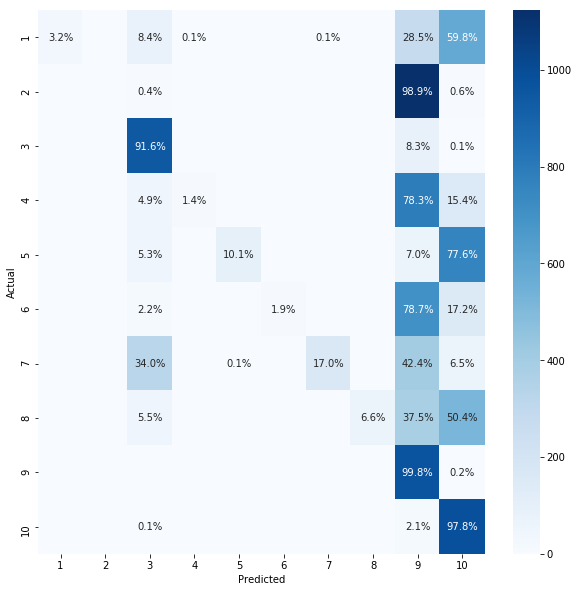

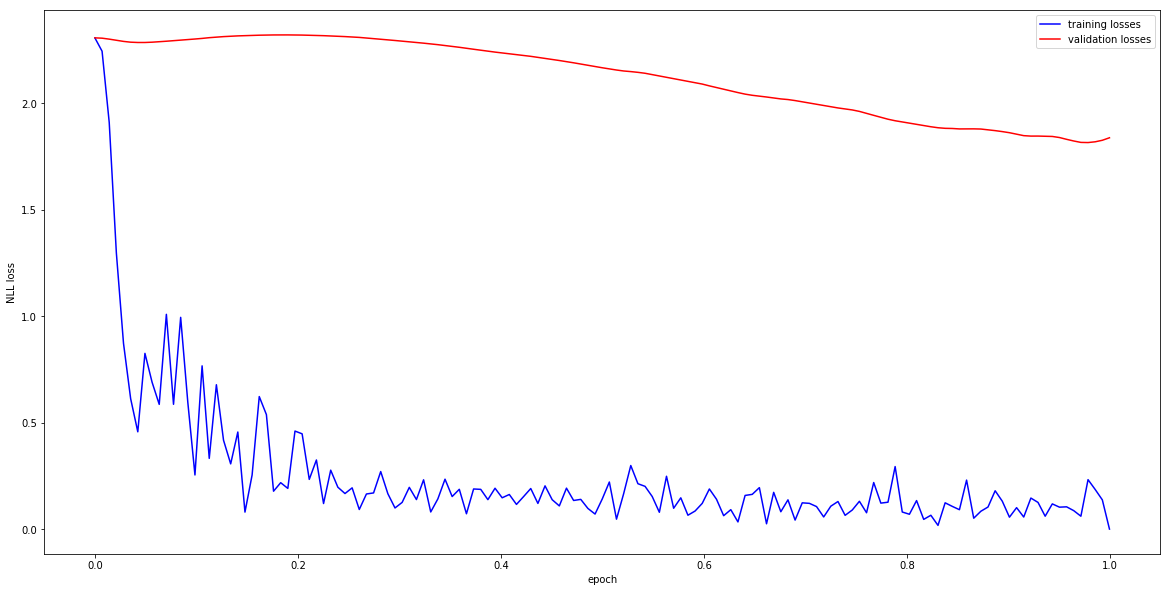

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

seed = 5
n_down = 7
p_down = 0.01

name = 'imb-nn-784-1000-1000-10-RN-'+str(seed)+'-'+str(n_down)+'-'+str(p_down)
model = NNRN()
model.to(device)
# rnn.cuda()

isImbalanced = True

print(model)
LR = 0.01               # learning rate

# optimizer = torch.optim.Adam(model.paameters(), lr=LR)  # optimize with Adam
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=LR)  # optimize with SGD

# loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
# loss_func = nn.CrossEntropyLoss().cuda()
# loss_func = nn.NLLLoss()

EPOCH = 1
train_losses = []
val_losses = []
test_acces = []

# training and testing
for epoch in range(EPOCH):
    if epoch == 0:
        x_history_stack=None
        COMP_stack=None
    train_losses, val_losses, x_history_stack, COMP_stack, used_train_size = train_RN(seed,n_down,p_down,model, device, train_loader, train_size, valid_loader, valid_size, optimizer, epoch, train_losses, val_losses,x_history_stack,COMP_stack,isImbalanced)
    test_acces, x_history_stack_test, COMP_stack_test, confusion_mtx = test_RN(model, device, test_loader, test_acces,x_history_stack,COMP_stack)
    
    torch.save(model.state_dict(),'mnist_'+name+'_epoch_'+str(epoch)+'.pt')
    
    fig = vis_confusion(confusion_mtx, np.arange(10)+1)
    fig.savefig('figures/'+name+'_confusion_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')

    plt.rcParams['figure.figsize'] = [20, 10]
    fig, ax = plt.subplots()
    ax.plot((np.arange(len(train_losses)))*BATCH_SIZE/used_train_size, train_losses, c='blue',label='training losses')
    ax.plot((np.arange(len(val_losses)))*BATCH_SIZE/used_train_size, val_losses, c='red',label='validation losses')
    ax.legend()
    ax.set_xlabel('epoch')
    ax.set_ylabel('NLL loss')
    fig.savefig('figures/'+name+'_loss_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')
    np.save('models/'+name+'_perf_epoch_'+str(epoch)+'.npy',[train_losses,val_losses,test_acces,confusion_mtx])

        

NNRLN(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
)
============================ tensor([0.0100, 0.0100, 1.0000, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 1.0000,
        1.0000])
epoch  0 :  0 / 18191  (0 %)  | train loss:2.2955 | val loss:2.3274 | val acc:0.1008 | Time:0.8542
epoch  0 :  128 / 18191  (1 %)  | train loss:2.3937 | val loss:2.3098 | val acc:0.0950 | Time:1.3150
epoch  0 :  256 / 18191  (1 %)  | train loss:1.9652 | val loss:2.3041 | val acc:0.0922 | Time:1.7763
epoch  0 :  384 / 18191  (2 %)  | train loss:1.0830 | val loss:2.3033 | val acc:0.1008 | Time:2.2351
epoch  0 :  512 / 18191  (3 %)  | train loss:0.8683 | val loss:2.3004 | val acc:0.0984 | Time:2.7285
epoch  0 :  640 / 18191  (4 %)  | train loss:1.9538 | val loss:2.2900 | val acc:0.1348 | Time:3.1953
epoch  0 :  768 / 18191  (4 %)  | train loss:0.5441 | val loss:2.2852 | 

epoch  0 :  9856 / 18191  (54 %)  | train loss:0.0587 | val loss:2.0955 | val acc:0.2332 | Time:40.3048
epoch  0 :  9984 / 18191  (55 %)  | train loss:0.1491 | val loss:2.0875 | val acc:0.2416 | Time:40.8962
epoch  0 :  10112 / 18191  (56 %)  | train loss:0.0950 | val loss:2.0808 | val acc:0.2402 | Time:41.4534
epoch  0 :  10240 / 18191  (56 %)  | train loss:0.2498 | val loss:2.0732 | val acc:0.2516 | Time:42.0143
epoch  0 :  10368 / 18191  (57 %)  | train loss:0.2163 | val loss:2.0651 | val acc:0.2644 | Time:42.5722
epoch  0 :  10496 / 18191  (58 %)  | train loss:0.0765 | val loss:2.0569 | val acc:0.2784 | Time:43.1335
epoch  0 :  10624 / 18191  (58 %)  | train loss:0.1455 | val loss:2.0516 | val acc:0.2782 | Time:43.6967
epoch  0 :  10752 / 18191  (59 %)  | train loss:0.0684 | val loss:2.0453 | val acc:0.2672 | Time:44.2964
epoch  0 :  10880 / 18191  (60 %)  | train loss:0.1711 | val loss:2.0386 | val acc:0.2630 | Time:44.8655
epoch  0 :  11008 / 18191  (61 %)  | train loss:0.0381 | 

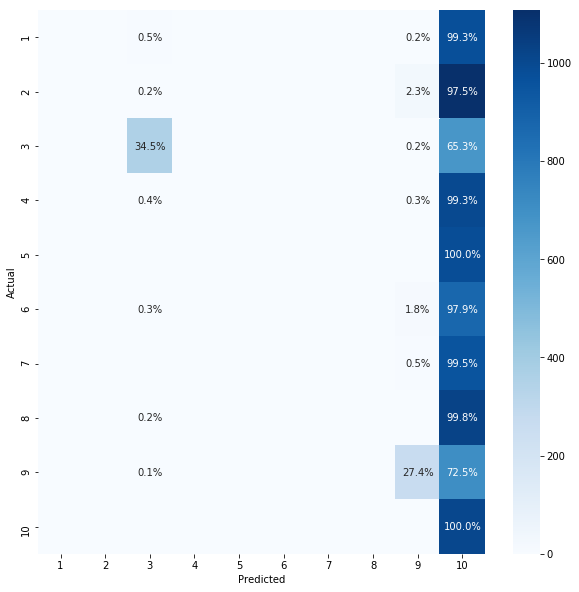

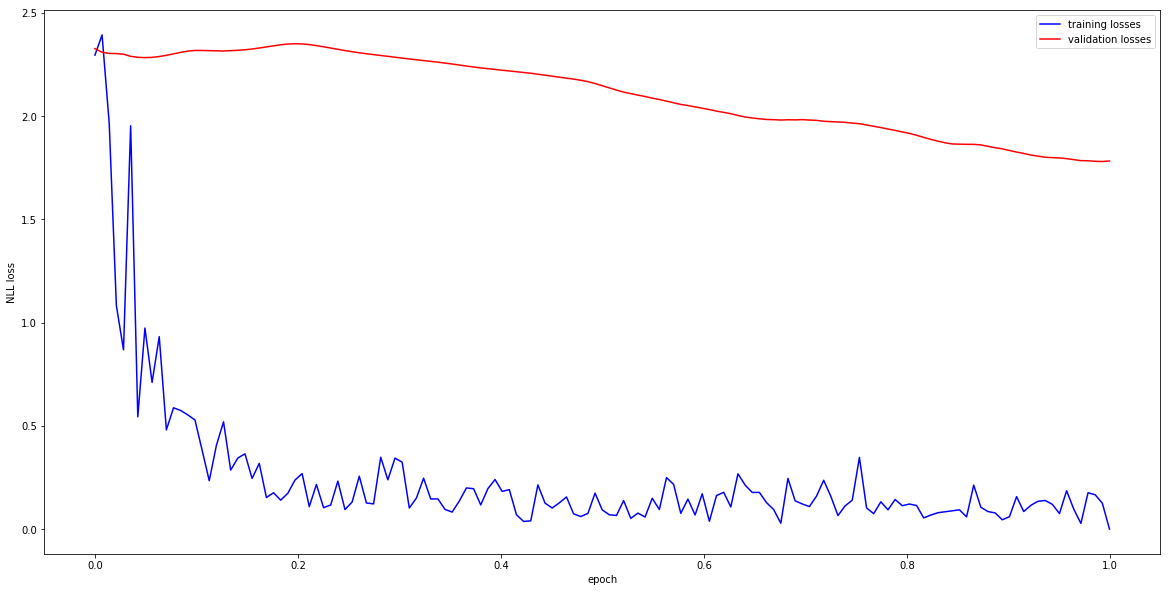

In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

seed = 5
n_down = 7
p_down = 0.01

name = 'imb-nn-784-1000-1000-10-RLN-'+str(seed)+'-'+str(n_down)+'-'+str(p_down)
model = NNRLN()
model.to(device)
# rnn.cuda()

isImbalanced = True

print(model)
LR = 0.01               # learning rate

# optimizer = torch.optim.Adam(model.paameters(), lr=LR)  # optimize with Adam
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=LR)  # optimize with SGD

# loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
# loss_func = nn.CrossEntropyLoss().cuda()
# loss_func = nn.NLLLoss()

EPOCH = 1
train_losses = []
val_losses = []
test_acces = []

# training and testing
for epoch in range(EPOCH):
    if epoch == 0:
        x_history_stack=None
        COMP_stack=None
    train_losses, val_losses, x_history_stack, COMP_stack, used_train_size = train_RN(seed,n_down,p_down,model, device, train_loader, train_size, valid_loader, valid_size, optimizer, epoch, train_losses, val_losses,x_history_stack,COMP_stack,isImbalanced)
    test_acces, x_history_stack_test, COMP_stack_test, confusion_mtx = test_RN(model, device, test_loader, test_acces,x_history_stack,COMP_stack)
    
    torch.save(model.state_dict(),'mnist_'+name+'_epoch_'+str(epoch)+'.pt')
    
    fig = vis_confusion(confusion_mtx, np.arange(10)+1)
    fig.savefig('figures/'+name+'_confusion_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')

    plt.rcParams['figure.figsize'] = [20, 10]
    fig, ax = plt.subplots()
    ax.plot((np.arange(len(train_losses)))*BATCH_SIZE/used_train_size, train_losses, c='blue',label='training losses')
    ax.plot((np.arange(len(val_losses)))*BATCH_SIZE/used_train_size, val_losses, c='red',label='validation losses')
    ax.legend()
    ax.set_xlabel('epoch')
    ax.set_ylabel('NLL loss')
    fig.savefig('figures/'+name+'_loss_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')
    np.save('models/'+name+'_perf_epoch_'+str(epoch)+'.npy',[train_losses,val_losses,test_acces,confusion_mtx])

        

NNRNLN(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
  (input_ln): LayerNorm(torch.Size([784]), eps=1e-05, elementwise_affine=True)
  (fc1_ln): LayerNorm(torch.Size([1000]), eps=1e-05, elementwise_affine=True)
  (fc2_ln): LayerNorm(torch.Size([1000]), eps=1e-05, elementwise_affine=True)
)
============================ tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0100, 1.0000, 1.0000,
        1.0000])
epoch  0 :  0 / 54144  (0 %)  | train loss:2.3007 | val loss:2.8992 | val acc:0.0944 | Time:0.8509
epoch  0 :  128 / 54144  (0 %)  | train loss:2.3452 | val loss:2.6248 | val acc:0.1008 | Time:1.3014
epoch  0 :  256 / 54144  (0 %)  | train loss:2.2784 | val loss:2.4004 | val acc:0.1392 | Time:1.7583
epoch  0 :  384 / 54144  (1 %)  | train loss:1.9330 | val loss:2.1748 | val acc:0.2534 | Time:2.2127
epoch  0 :  512 / 54144  (1 %)  | trai

epoch  0 :  9600 / 54144  (18 %)  | train loss:0.5384 | val loss:0.8174 | val acc:0.8800 | Time:39.1451
epoch  0 :  9728 / 54144  (18 %)  | train loss:0.4124 | val loss:0.8068 | val acc:0.8810 | Time:39.6920
epoch  0 :  9856 / 54144  (18 %)  | train loss:0.4218 | val loss:0.8099 | val acc:0.8682 | Time:40.2367
epoch  0 :  9984 / 54144  (18 %)  | train loss:1.0582 | val loss:0.8121 | val acc:0.8700 | Time:40.7828
epoch  0 :  10112 / 54144  (19 %)  | train loss:0.6144 | val loss:0.8243 | val acc:0.8770 | Time:41.3725
epoch  0 :  10240 / 54144  (19 %)  | train loss:0.3540 | val loss:0.8491 | val acc:0.8742 | Time:41.9217
epoch  0 :  10368 / 54144  (19 %)  | train loss:0.1254 | val loss:0.8825 | val acc:0.8520 | Time:42.4904
epoch  0 :  10496 / 54144  (19 %)  | train loss:0.4643 | val loss:0.8635 | val acc:0.8590 | Time:43.0455
epoch  0 :  10624 / 54144  (20 %)  | train loss:0.4365 | val loss:0.8387 | val acc:0.8638 | Time:43.6073
epoch  0 :  10752 / 54144  (20 %)  | train loss:0.6050 | va

epoch  0 :  19712 / 54144  (36 %)  | train loss:0.2072 | val loss:0.5405 | val acc:0.8714 | Time:88.8920
epoch  0 :  19840 / 54144  (37 %)  | train loss:0.3180 | val loss:0.5949 | val acc:0.8438 | Time:89.6200
epoch  0 :  19968 / 54144  (37 %)  | train loss:0.4505 | val loss:0.5708 | val acc:0.8568 | Time:90.3554
epoch  0 :  20096 / 54144  (37 %)  | train loss:0.2939 | val loss:0.5502 | val acc:0.8640 | Time:91.0837
epoch  0 :  20224 / 54144  (37 %)  | train loss:0.3398 | val loss:0.5618 | val acc:0.8502 | Time:91.8499
epoch  0 :  20352 / 54144  (38 %)  | train loss:0.4133 | val loss:0.5574 | val acc:0.8480 | Time:92.5805
epoch  0 :  20480 / 54144  (38 %)  | train loss:0.2487 | val loss:0.5164 | val acc:0.8724 | Time:93.3100
epoch  0 :  20608 / 54144  (38 %)  | train loss:0.2921 | val loss:0.4826 | val acc:0.8886 | Time:94.0378
epoch  0 :  20736 / 54144  (38 %)  | train loss:0.2443 | val loss:0.4809 | val acc:0.8928 | Time:94.7694
epoch  0 :  20864 / 54144  (39 %)  | train loss:0.1937 

epoch  0 :  29696 / 54144  (55 %)  | train loss:0.4039 | val loss:0.3227 | val acc:0.9228 | Time:150.3835
epoch  0 :  29824 / 54144  (55 %)  | train loss:0.1049 | val loss:0.3083 | val acc:0.9328 | Time:151.2648
epoch  0 :  29952 / 54144  (55 %)  | train loss:0.2849 | val loss:0.3007 | val acc:0.9378 | Time:152.1147
epoch  0 :  30080 / 54144  (56 %)  | train loss:0.1854 | val loss:0.3057 | val acc:0.9340 | Time:152.9661
epoch  0 :  30208 / 54144  (56 %)  | train loss:0.2327 | val loss:0.3087 | val acc:0.9336 | Time:153.8351
epoch  0 :  30336 / 54144  (56 %)  | train loss:0.3350 | val loss:0.2950 | val acc:0.9354 | Time:154.6886
epoch  0 :  30464 / 54144  (56 %)  | train loss:0.1429 | val loss:0.2957 | val acc:0.9380 | Time:155.5829
epoch  0 :  30592 / 54144  (57 %)  | train loss:0.2102 | val loss:0.3113 | val acc:0.9272 | Time:156.4431
epoch  0 :  30720 / 54144  (57 %)  | train loss:0.1806 | val loss:0.3354 | val acc:0.9124 | Time:157.2982
epoch  0 :  30848 / 54144  (57 %)  | train los

epoch  0 :  39680 / 54144  (73 %)  | train loss:0.0947 | val loss:0.3061 | val acc:0.9190 | Time:224.6190
epoch  0 :  39808 / 54144  (74 %)  | train loss:0.2502 | val loss:0.3103 | val acc:0.9244 | Time:225.6349
epoch  0 :  39936 / 54144  (74 %)  | train loss:0.3209 | val loss:0.3096 | val acc:0.9252 | Time:226.6859
epoch  0 :  40064 / 54144  (74 %)  | train loss:0.1527 | val loss:0.2997 | val acc:0.9330 | Time:227.7021
epoch  0 :  40192 / 54144  (74 %)  | train loss:0.1494 | val loss:0.3015 | val acc:0.9316 | Time:228.7174
epoch  0 :  40320 / 54144  (74 %)  | train loss:0.0882 | val loss:0.3113 | val acc:0.9294 | Time:229.7384
epoch  0 :  40448 / 54144  (75 %)  | train loss:0.3438 | val loss:0.3099 | val acc:0.9272 | Time:230.7696
epoch  0 :  40576 / 54144  (75 %)  | train loss:0.0559 | val loss:0.3200 | val acc:0.9200 | Time:231.7888
epoch  0 :  40704 / 54144  (75 %)  | train loss:0.1953 | val loss:0.3229 | val acc:0.9146 | Time:232.8413
epoch  0 :  40832 / 54144  (75 %)  | train los

epoch  0 :  49664 / 54144  (92 %)  | train loss:0.0819 | val loss:0.2512 | val acc:0.9336 | Time:308.6808
epoch  0 :  49792 / 54144  (92 %)  | train loss:0.2843 | val loss:0.2265 | val acc:0.9434 | Time:309.8186
epoch  0 :  49920 / 54144  (92 %)  | train loss:0.0951 | val loss:0.2175 | val acc:0.9470 | Time:311.1059
epoch  0 :  50048 / 54144  (92 %)  | train loss:0.0601 | val loss:0.2191 | val acc:0.9450 | Time:312.3001
epoch  0 :  50176 / 54144  (93 %)  | train loss:0.0638 | val loss:0.2269 | val acc:0.9406 | Time:313.5428
epoch  0 :  50304 / 54144  (93 %)  | train loss:0.1271 | val loss:0.2395 | val acc:0.9370 | Time:314.6703
epoch  0 :  50432 / 54144  (93 %)  | train loss:0.2217 | val loss:0.2389 | val acc:0.9374 | Time:315.8740
epoch  0 :  50560 / 54144  (93 %)  | train loss:0.1508 | val loss:0.2309 | val acc:0.9410 | Time:317.0919
epoch  0 :  50688 / 54144  (94 %)  | train loss:0.1458 | val loss:0.2405 | val acc:0.9346 | Time:318.3704
epoch  0 :  50816 / 54144  (94 %)  | train los

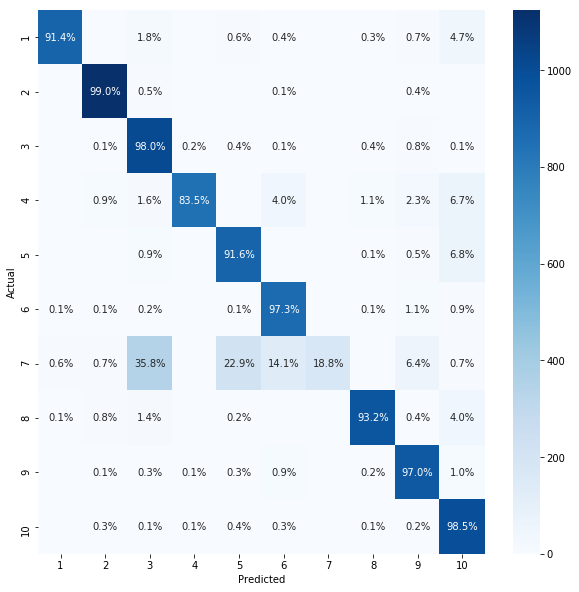

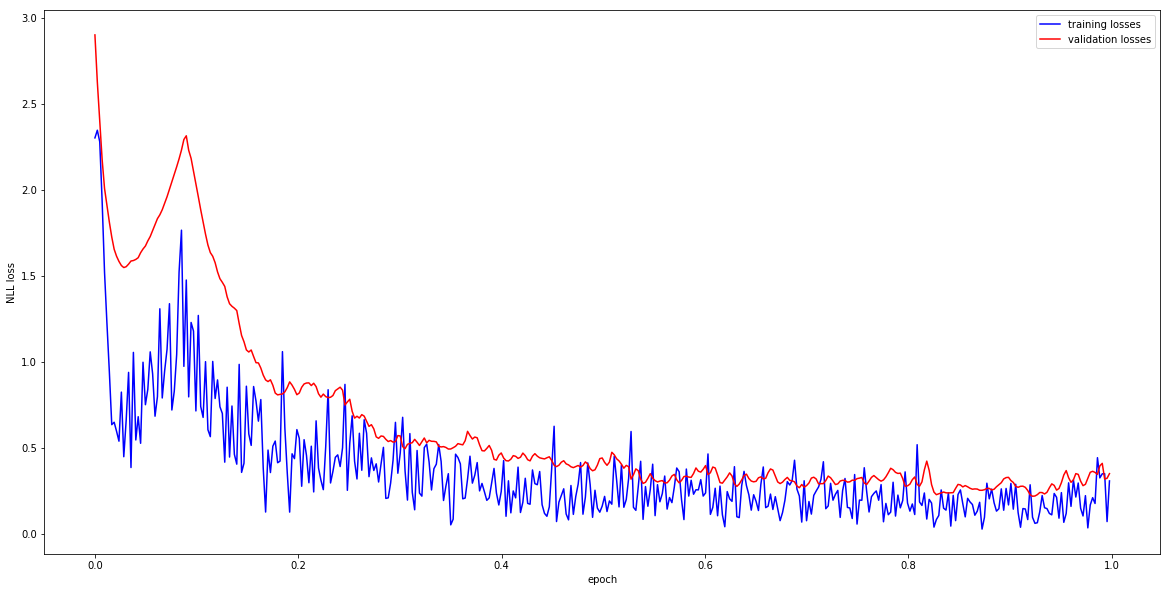

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

seed = 5
n_down = 1
p_down = 0.01

name = 'imb-nn-784-1000-1000-10-RNLN-'+str(seed)+'-'+str(n_down)+'-'+str(p_down)
model = NNRNLN()
model.to(device)
# rnn.cuda()

isImbalanced = True

print(model)
LR = 0.01               # learning rate

# optimizer = torch.optim.Adam(model.paameters(), lr=LR)  # optimize with Adam
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=LR)  # optimize with SGD

# loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
# loss_func = nn.CrossEntropyLoss().cuda()
# loss_func = nn.NLLLoss()

EPOCH = 1
train_losses = []
val_losses = []
test_acces = []

# training and testing
for epoch in range(EPOCH):
    if epoch == 0:
        x_history_stack=None
        COMP_stack=None
    train_losses, val_losses, x_history_stack, COMP_stack, used_train_size = train_RN(seed,n_down,p_down,model, device, train_loader, train_size, valid_loader, valid_size, optimizer, epoch, train_losses, val_losses,x_history_stack,COMP_stack,isImbalanced)
    test_acces, x_history_stack_test, COMP_stack_test, confusion_mtx = test_RN(model, device, test_loader, test_acces,x_history_stack,COMP_stack)
    
    torch.save(model.state_dict(),'mnist_'+name+'_epoch_'+str(epoch)+'.pt')
    
    fig = vis_confusion(confusion_mtx, np.arange(10)+1)
    fig.savefig('figures/'+name+'_confusion_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')

    plt.rcParams['figure.figsize'] = [20, 10]
    fig, ax = plt.subplots()
    ax.plot((np.arange(len(train_losses)))*BATCH_SIZE/used_train_size, train_losses, c='blue',label='training losses')
    ax.plot((np.arange(len(val_losses)))*BATCH_SIZE/used_train_size, val_losses, c='red',label='validation losses')
    ax.legend()
    ax.set_xlabel('epoch')
    ax.set_ylabel('NLL loss')
    fig.savefig('figures/'+name+'_loss_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')
    np.save('models/'+name+'_perf_epoch_'+str(epoch)+'.npy',[train_losses,val_losses,test_acces,confusion_mtx])

        

NNSN(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
)
============================ tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0100, 1.0000, 1.0000,
        1.0000])
epoch  0 :  0 / 54149  (0 %)  | train loss:2.4202 | val loss:2.5326 | val acc:0.1074 | Time:0.8184
epoch  0 :  128 / 54149  (0 %)  | train loss:2.0688 | val loss:2.2157 | val acc:0.1888 | Time:1.2681
epoch  0 :  256 / 54149  (0 %)  | train loss:1.6078 | val loss:2.0844 | val acc:0.3022 | Time:1.7130
epoch  0 :  384 / 54149  (1 %)  | train loss:1.5478 | val loss:1.9951 | val acc:0.3638 | Time:2.1965
epoch  0 :  512 / 54149  (1 %)  | train loss:1.3227 | val loss:1.9253 | val acc:0.4420 | Time:2.6945
epoch  0 :  640 / 54149  (1 %)  | train loss:0.6828 | val loss:1.8777 | val acc:0.5178 | Time:3.1425
epoch  0 :  768 / 54149  (1 %)  | train loss:1.2762 | val loss:1.8508 | v

epoch  0 :  9856 / 54149  (18 %)  | train loss:0.5102 | val loss:2.1757 | val acc:0.8078 | Time:40.1082
epoch  0 :  9984 / 54149  (18 %)  | train loss:0.2999 | val loss:2.1720 | val acc:0.8146 | Time:40.6970
epoch  0 :  10112 / 54149  (19 %)  | train loss:0.2956 | val loss:2.1675 | val acc:0.8188 | Time:41.2860
epoch  0 :  10240 / 54149  (19 %)  | train loss:0.4623 | val loss:2.1627 | val acc:0.8182 | Time:41.8364
epoch  0 :  10368 / 54149  (19 %)  | train loss:0.4911 | val loss:2.1602 | val acc:0.8146 | Time:42.3932
epoch  0 :  10496 / 54149  (19 %)  | train loss:0.2916 | val loss:2.1535 | val acc:0.8064 | Time:42.9435
epoch  0 :  10624 / 54149  (20 %)  | train loss:0.5991 | val loss:2.1456 | val acc:0.8330 | Time:43.4987
epoch  0 :  10752 / 54149  (20 %)  | train loss:0.6950 | val loss:2.1386 | val acc:0.8334 | Time:44.0845
epoch  0 :  10880 / 54149  (20 %)  | train loss:0.3753 | val loss:2.1307 | val acc:0.7940 | Time:44.6413
epoch  0 :  11008 / 54149  (20 %)  | train loss:0.2659 | 

epoch  0 :  19968 / 54149  (37 %)  | train loss:0.2936 | val loss:1.8396 | val acc:0.8716 | Time:90.8052
epoch  0 :  20096 / 54149  (37 %)  | train loss:0.1663 | val loss:1.8201 | val acc:0.8836 | Time:91.4656
epoch  0 :  20224 / 54149  (37 %)  | train loss:0.3375 | val loss:1.8098 | val acc:0.8856 | Time:92.1578
epoch  0 :  20352 / 54149  (38 %)  | train loss:0.2153 | val loss:1.8009 | val acc:0.8900 | Time:92.8221
epoch  0 :  20480 / 54149  (38 %)  | train loss:0.3582 | val loss:1.7922 | val acc:0.8984 | Time:93.4860
epoch  0 :  20608 / 54149  (38 %)  | train loss:0.2248 | val loss:1.7865 | val acc:0.8980 | Time:94.1557
epoch  0 :  20736 / 54149  (38 %)  | train loss:0.1866 | val loss:1.7827 | val acc:0.8850 | Time:94.8214
epoch  0 :  20864 / 54149  (39 %)  | train loss:0.2715 | val loss:1.7798 | val acc:0.8782 | Time:95.4890
epoch  0 :  20992 / 54149  (39 %)  | train loss:0.3868 | val loss:1.7780 | val acc:0.8812 | Time:96.1991
epoch  0 :  21120 / 54149  (39 %)  | train loss:0.5492 

epoch  0 :  29952 / 54149  (55 %)  | train loss:0.2590 | val loss:1.4786 | val acc:0.8758 | Time:148.1427
epoch  0 :  30080 / 54149  (56 %)  | train loss:0.4160 | val loss:1.4995 | val acc:0.8766 | Time:148.9655
epoch  0 :  30208 / 54149  (56 %)  | train loss:0.2263 | val loss:1.5252 | val acc:0.8776 | Time:149.7882
epoch  0 :  30336 / 54149  (56 %)  | train loss:0.3119 | val loss:1.5545 | val acc:0.8740 | Time:150.6097
epoch  0 :  30464 / 54149  (56 %)  | train loss:0.2952 | val loss:1.5764 | val acc:0.8650 | Time:151.4641
epoch  0 :  30592 / 54149  (56 %)  | train loss:0.1723 | val loss:1.5860 | val acc:0.8660 | Time:152.2912
epoch  0 :  30720 / 54149  (57 %)  | train loss:0.2204 | val loss:1.5620 | val acc:0.8724 | Time:153.1162
epoch  0 :  30848 / 54149  (57 %)  | train loss:0.3094 | val loss:1.5316 | val acc:0.8894 | Time:153.9142
epoch  0 :  30976 / 54149  (57 %)  | train loss:0.2451 | val loss:1.5007 | val acc:0.8796 | Time:154.7172
epoch  0 :  31104 / 54149  (57 %)  | train los

epoch  0 :  39936 / 54149  (74 %)  | train loss:0.4059 | val loss:1.3129 | val acc:0.8842 | Time:215.8722
epoch  0 :  40064 / 54149  (74 %)  | train loss:0.3936 | val loss:1.3338 | val acc:0.8820 | Time:216.8038
epoch  0 :  40192 / 54149  (74 %)  | train loss:0.2734 | val loss:1.3439 | val acc:0.8758 | Time:217.7364
epoch  0 :  40320 / 54149  (74 %)  | train loss:0.4172 | val loss:1.3424 | val acc:0.8890 | Time:218.7251
epoch  0 :  40448 / 54149  (75 %)  | train loss:0.5237 | val loss:1.3377 | val acc:0.9142 | Time:219.6810
epoch  0 :  40576 / 54149  (75 %)  | train loss:0.3572 | val loss:1.3179 | val acc:0.9270 | Time:220.6246
epoch  0 :  40704 / 54149  (75 %)  | train loss:0.2160 | val loss:1.2962 | val acc:0.9244 | Time:221.6029
epoch  0 :  40832 / 54149  (75 %)  | train loss:0.1958 | val loss:1.2854 | val acc:0.9106 | Time:222.5532
epoch  0 :  40960 / 54149  (76 %)  | train loss:0.2534 | val loss:1.2722 | val acc:0.9120 | Time:223.5000
epoch  0 :  41088 / 54149  (76 %)  | train los

epoch  0 :  49920 / 54149  (92 %)  | train loss:0.3783 | val loss:1.2259 | val acc:0.8596 | Time:294.2961
epoch  0 :  50048 / 54149  (92 %)  | train loss:0.4324 | val loss:1.2359 | val acc:0.8676 | Time:295.3027
epoch  0 :  50176 / 54149  (93 %)  | train loss:0.3539 | val loss:1.2352 | val acc:0.8886 | Time:296.3390
epoch  0 :  50304 / 54149  (93 %)  | train loss:0.3007 | val loss:1.2372 | val acc:0.9020 | Time:297.3448
epoch  0 :  50432 / 54149  (93 %)  | train loss:0.2574 | val loss:1.2367 | val acc:0.9112 | Time:298.3569
epoch  0 :  50560 / 54149  (93 %)  | train loss:0.2706 | val loss:1.2352 | val acc:0.9160 | Time:299.3675
epoch  0 :  50688 / 54149  (94 %)  | train loss:0.1869 | val loss:1.2235 | val acc:0.9168 | Time:300.3771
epoch  0 :  50816 / 54149  (94 %)  | train loss:0.4214 | val loss:1.2204 | val acc:0.9148 | Time:301.4266
epoch  0 :  50944 / 54149  (94 %)  | train loss:0.2048 | val loss:1.2125 | val acc:0.9094 | Time:302.4470
epoch  0 :  51072 / 54149  (94 %)  | train los

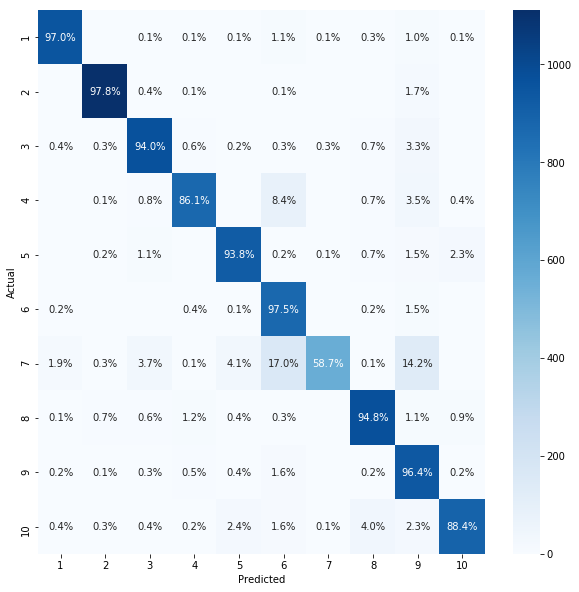

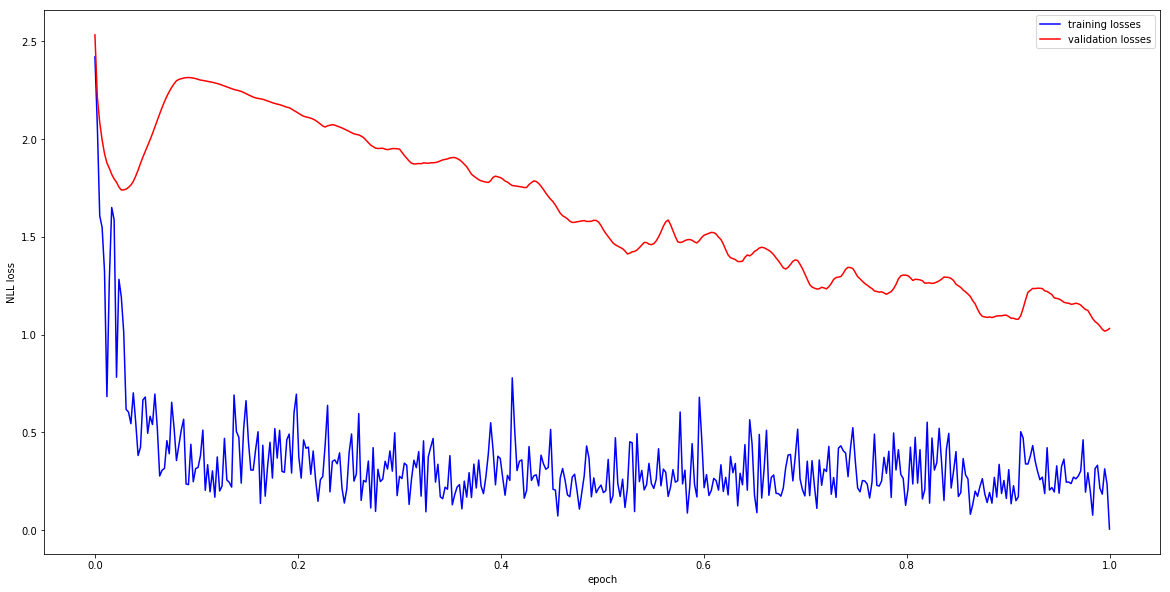

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

seed = 5
n_down = 1
p_down = 0.01

name = 'imb-nn-784-1000-1000-10-SN-'+str(seed)+'-'+str(n_down)+'-'+str(p_down)
model = NNSN()
model.to(device)
# rnn.cuda()
isImbalanced = True

print(model)
LR = 0.01               # learning rate

# optimizer = torch.optim.Adam(model.paameters(), lr=LR)  # optimize with Adam
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=LR)  # optimize with SGD

# loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
# loss_func = nn.CrossEntropyLoss().cuda()
# loss_func = nn.NLLLoss()

EPOCH = 1
train_losses = []
val_losses = []
test_acces = []

# training and testing
for epoch in range(EPOCH):
    if epoch == 0:
        x_history_stack=None
        COMP_stack=None
    train_losses, val_losses, x_history_stack, COMP_stack, used_train_size = train_SN(seed,n_down,p_down,model, device, train_loader, train_size, valid_loader, valid_size, optimizer, epoch, train_losses, val_losses,x_history_stack,COMP_stack,isImbalanced)
    test_acces, x_history_stack_test, COMP_stack_test, confusion_mtx = test_SN(model, device, test_loader, test_acces,x_history_stack,COMP_stack)
    
    torch.save(model.state_dict(),'mnist_'+name+'_epoch_'+str(epoch)+'.pt')
    
    fig = vis_confusion(confusion_mtx, np.arange(10)+1)
    fig.savefig('figures/'+name+'_confusion_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')

    plt.rcParams['figure.figsize'] = [20, 10]
    fig, ax = plt.subplots()
    ax.plot((np.arange(len(train_losses)))*BATCH_SIZE/used_train_size, train_losses, c='blue',label='training losses')
    ax.plot((np.arange(len(val_losses)))*BATCH_SIZE/used_train_size, val_losses, c='red',label='validation losses')
    ax.legend()
    ax.set_xlabel('epoch')
    ax.set_ylabel('NLL loss')
    fig.savefig('figures/'+name+'_loss_epoch_'+str(epoch)+'_acc_'+str(test_acces[-1])+'.png')
    np.save('models/'+name+'_perf_epoch_'+str(epoch)+'.npy',[train_losses,val_losses,test_acces,confusion_mtx])

        